# Wholesale Customer Loyalty Data Challenge

# Summary

### Problem Statement

You work at a small food service supply wholesaler that principally services the
hotel restaurant and retail channels. Currently, your company is working on designing a
customer loyalty program but your CEO is unsure of the best way to proceed - the
current thinking is a loyalty program that incentivizes customers to purchase across
multiple offering categories (e.g., if a customer purchases from the grocery, frozen, and
deli categories, they receive a discount).

Your CEO would like you to **examine annual spending by the company’s current
customers to understand if such a program would be attractive to the largest subgroup
of customers.**

Available Data:
- CUST_ID: Customer ID
- YEAR: Year
- FRESH: annual spending on fresh products
- DAIRY: annual spending on dairy products
- GROCERY: annual spending on grocery products
- FROZEN: annual spending on frozen products
- DETERGENTS_PAPER: annual spending on detergents and paper products
- DELI: annual spending on delicatessen products
- CHANNEL: HoReCa (hotel/restaurant) or Retail

### Outline of Analysis Steps

Initial To Do List
- original basic stats
- clean data (quantify and remove missing data; quantify and remove duplicates, fix datatypes)
- look for correlations between categories, basic stats plots
- remove outliers
- plot kmeans clusters.

Additional steps taken with new information:
- sdf

# Data Prep

### Load libraries, data, and get first glimpse

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
cust = pd.read_csv('wholesale_data.csv')
cust.head()

,Channel,Customer,Year,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,6048141,2017,12669,9656,7561,214,2674,1338
1,2,9336325,2017,7057,9810,9568,1762,3293,1776
2,2,6272942,2017,6353,8808,7684,2405,3516,7844
3,1,7856217,2017,13265,1196,4221,6404,507,1788
4,2,6179511,2017,22615,5410,7198,3915,1777,5185


In [3]:
# Row count
print("Number of rows: ", str(cust.shape[0]))

# Column count
print("\nNumber of columns: ", str(cust.shape[1]))

# Column names
print("\nColumn names: ", str(cust.columns))

# Indexing method
print("\nIndex method: ", cust.index)

# Data types of all columns
print("\nData types for entire dataframe: ")
cust.info()

Number of rows:  801

Number of columns:  9

Column names:  Index(['Channel', 'Customer', 'Year', 'Fresh', 'Milk', 'Grocery', 'Frozen',
       'Detergents_Paper', 'Delicassen'],
      dtype='object')

Index method:  RangeIndex(start=0, stop=801, step=1)

Data types for entire dataframe: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 801 entries, 0 to 800
Data columns (total 9 columns):
Channel             801 non-null int64
Customer            801 non-null int64
Year                801 non-null object
Fresh               799 non-null object
Milk                798 non-null object
Grocery             798 non-null object
Frozen              798 non-null object
Detergents_Paper    799 non-null object
Delicassen          797 non-null object
dtypes: int64(2), object(7)
memory usage: 56.4+ KB


### Data Cleaning

Based on the initial glimpse from above and looking at the unique values for each column, it looks like the following datatypes need to be modified:
- Channel and Customer should not be treated as ints
- All other columns should be ints
- Convert Year column values of '08/01/2016' to just 2016

Additionally, even though there are 801 rows, there are not 801 non-null values for all columns. We'll throw out those rows and see how many rows we lose in total, as well as check for duplcates.



In [4]:
cust = cust.dropna()
cust = cust.drop_duplicates()
cust = cust[cust.Fresh != 'unrecorded']
cust = cust[cust.Milk != 'unrecorded']
cust = cust[cust.Grocery != 'unrecorded']
cust = cust[cust.Frozen != 'unrecorded']
cust = cust[cust.Detergents_Paper != 'unrecorded']
cust = cust[cust.Delicassen != 'unrecorded']
print("Number of rows: ", str(cust.shape[0]))


Number of rows:  770


Drop down to 770 rows when dropping any rows with missing data or 'unrecorded' written as values which isn't too bad, so for sake of time will just continue on with those 770. There were no duplicate rows.

In [5]:
cust.Year.unique()

array(['2017', '08/01/2016'], dtype=object)

In [6]:
# formatting the Year column to be more uniform
def fixYear(year):
    """
    a simple function to convert formatting for the year column
    """
    if year == '08/01/2016':
        new_year = '2016'
    else:
        new_year = year
    return new_year

cust['Year'] = cust.Year.apply(fixYear)
cust.Year.unique()
    

array(['2017', '2016'], dtype=object)

In [7]:
# datatype conversions
cust.Channel = cust.Channel.astype(str)
cust.Customer = cust.Customer.astype(str)
cust.Fresh = cust.Fresh.astype(int)
cust.Milk = cust.Milk.astype(int)
cust.Grocery = cust.Grocery.astype(int)
cust.Frozen = cust.Frozen.astype(int)
cust.Detergents_Paper = cust.Detergents_Paper.astype(int)
cust.Delicassen = cust.Delicassen.astype(int)
cust.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 770 entries, 0 to 800
Data columns (total 9 columns):
Channel             770 non-null object
Customer            770 non-null object
Year                770 non-null object
Fresh               770 non-null int64
Milk                770 non-null int64
Grocery             770 non-null int64
Frozen              770 non-null int64
Detergents_Paper    770 non-null int64
Delicassen          770 non-null int64
dtypes: int64(6), object(3)
memory usage: 60.2+ KB


# Exploratory Data Analysis

Basic stats breakdown by year and by Channel

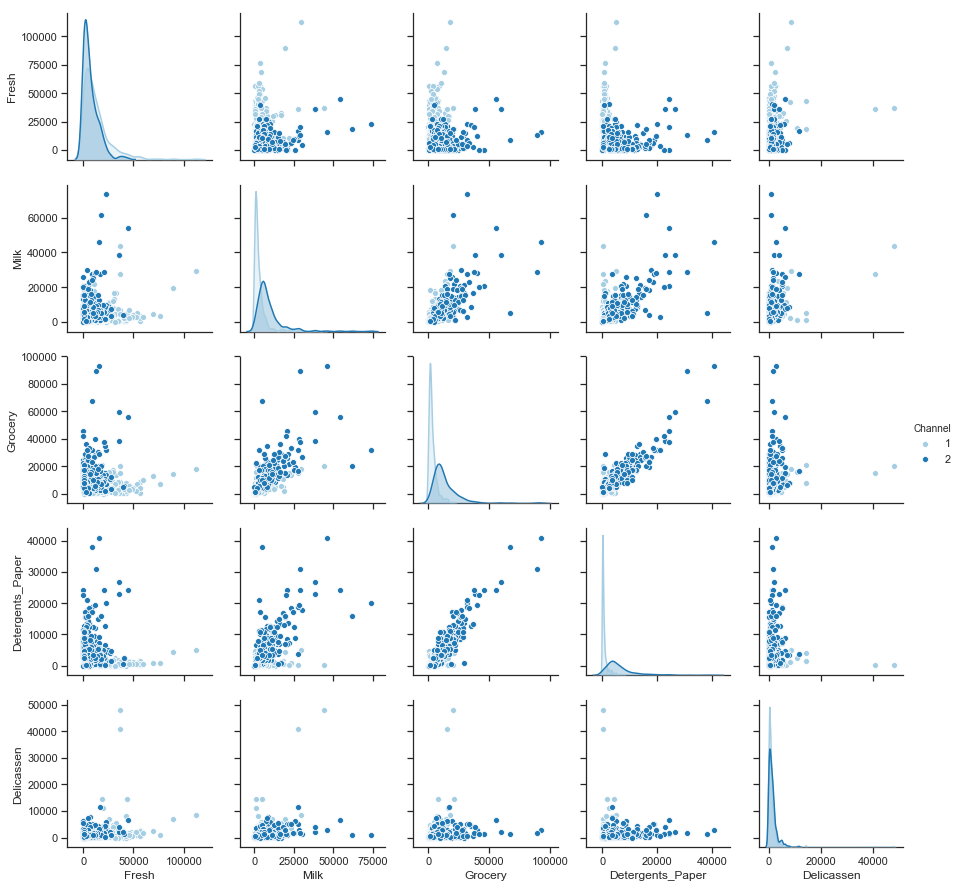

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# Paired plot comparing Channel (hotels/restaurants versus retail)
sns.set(style = 'ticks', color_codes = True)
sns.pairplot(cust, 
             hue = 'Channel', 
             palette = "Paired", 
             vars = ['Fresh', 'Milk', 'Grocery', 'Detergents_Paper', 'Delicassen'])

Seems to be similar spending between hotel/restuarant and retail for Fresh and Delicassen goods, and more divergence in Milk, Grocery, and Detergents_Paper category. This seems to be driven by Channel 2 (retail?) having more variation in amount of annual spending.

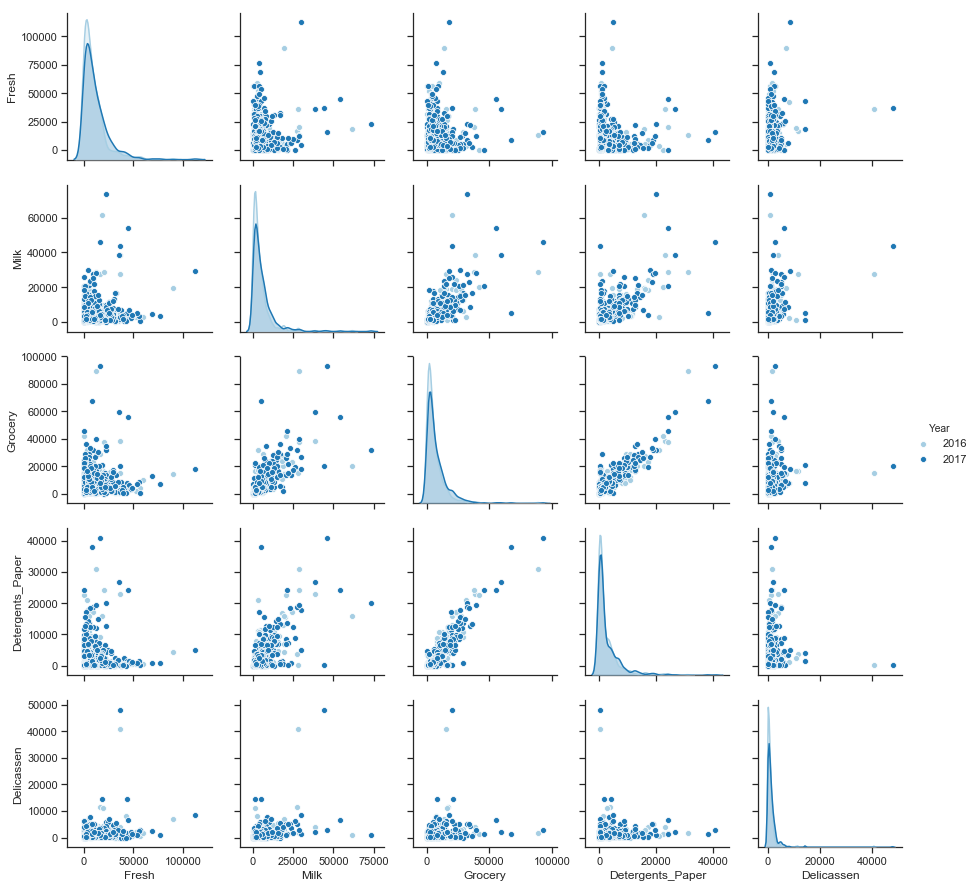

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# Paired plot comparing Years (2016 vs 2017)
sns.set(style = 'ticks', color_codes = True)
sns.pairplot(cust, 
             hue = 'Year', 
             palette = "Paired", 
             vars = ['Fresh', 'Milk', 'Grocery', 'Detergents_Paper', 'Delicassen'])


There does not appear to be too much year to year variation in spending patterns between 2016 and 2017.

In [ ]:
# box plots
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

sns.set(color_codes=True)

sns.boxplot(x="total_price_bins", y="total_price", hue="sold_true", data=books[(books.price < 40)], palette="Set3")

In [ ]:
# Paired grid/paired plots

In [4]:
# Scatterplots

In [5]:
# Histograms
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

sns.set(color_codes=True)

sns.distplot(x, bins=20, kde=False, rug=True);
# Tweak using Matplotlib
plt.ylim(0, None)
plt.xlim(0, 60)

In [6]:
# Barplot

In [7]:
# Heatmap

In [8]:
# Colinearity

# Basic Feature Engineeering

# Basic Modelling

In [ ]:
# scipy t-test

In [ ]:
# statsmodel for regression

In [ ]:
# Unsupervised learning Kmeans
from sklearn import cluster, datasets
iris = datasets.load_iris()
X_iris = iris.data

k_means = cluster.KMeans(n_clusters=3)
k_means.fit(X_iris) 
print(k_means.labels_[::10])

# Validation

In [ ]:
from sklearn.metrics import classification_report
y_true = [0, 1, 2, 2, 2]
y_pred = [0, 0, 2, 2, 1]
target_names = ['class 0', 'class 1', 'class 2']
print(classification_report(y_true, y_pred, target_names=target_names))

# Results and Recommendations